# Business Data and Understanding

This presentation will analyze a current dataset that captures unique information about specific houses and the sale price of that home in King County, Washington State. 

The object of the analysis will be use the data to provide a local real estate agency with relevant advice to homeowners that are considering renovating their home in an effort to increase the value of the home. 


In [293]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

df = pd.read_csv('kc_house_data.csv')

In [294]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [295]:


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Data Cleaning



### Dealing with Null Values

An initial view of the data shows that there are some null values in waterfront, view and yr_renovated columns.

In [296]:
#dive deeper into null values

df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [297]:
#I'll assume that these houses don't have waterfont property if they weren't 
#listed as such and change all valeus to "NO"

df['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

In [298]:
df['waterfront'].fillna(value='NO', inplace=True)

In [299]:
df['waterfront'].isna().sum()

0

In [300]:
# since 'Yes' and 'No' values are binary, let's transform these into
# 1's and 0's so we don't have to one hot encode them 

df['waterfront_binary'] = df['waterfront'].map(lambda x: 1 if x == 'YES' else 0)

In [301]:
df.drop(['waterfront'], axis=1, inplace=True )

In [302]:
#similar to the above, I'll assume that there is no view if it wasn't marked
# as such in the survey

df['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [303]:
df['view'].fillna(value='NONE', inplace=True)

In [304]:
df['view'].isna().sum()

0

In [305]:
# we'll also assume that null values here denote houses that have not been
# renovated

df['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1948.0        1
1951.0        1
1971.0        1
1934.0        1
1944.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [306]:
df['yr_renovated'].fillna(value=0.0, inplace=True)

In [307]:
df['yr_renovated'].isna().sum()

0

In [308]:
df['renovated'] = df['yr_renovated'].map(lambda x: 1 if x>0.0 else 0)

### Dealing with Outliers

The real estate agency would like to advise as many home owners as possible on how they can use renovations to increase property values. 

In order to do that, we'll have to remove extreme values from the data set since we are not in skewing the data set. 


In [309]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_binary,renovated
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,68.758207,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,0.006760,0.034449
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,364.037499,53.513072,0.138552,0.140724,685.230472,27274.441950,0.081944,0.182384
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,0.000000,0.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,0.000000,0.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,0.000000,0.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,0.000000,0.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,1.000000,1.000000


In [310]:
import numpy as np

# the price column contains some homes that are in the 7 figure range, 
# which is far higher than the 75% percentile of homes. Let's remove 
# super high value homes. 

price_values = list(df['price'])
high_prices = np.percentile(price_values, 90)

In [311]:
df = df[df['price']<= high_prices]

In [312]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_binary,renovated
count,1.943800e+04,19438.000000,19438.000000,19438.000000,19438.000000,1.943800e+04,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000
mean,4.617690e+09,450887.012450,3.301626,2.014829,1915.240457,1.416968e+04,1.461261,1658.374113,1970.634890,56.543935,98078.864904,47.553664,-122.213652,1879.543935,12210.534674,0.002058,0.028347
std,2.877883e+09,177692.522191,0.902130,0.689136,721.095250,3.853956e+04,0.535503,679.209312,28.997698,331.068869,53.329737,0.143003,0.142931,573.727540,25642.600832,0.045318,0.165965
min,1.000102e+06,78000.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,0.000000,0.000000
25%,2.141380e+09,310000.000000,3.000000,1.500000,1370.000000,5.000000e+03,1.000000,1160.000000,1951.000000,0.000000,98033.000000,47.452200,-122.331000,1460.000000,5029.000000,0.000000,0.000000
50%,3.922150e+09,425000.000000,3.000000,2.000000,1820.000000,7.482000e+03,1.000000,1480.000000,1974.000000,0.000000,98065.000000,47.562500,-122.236000,1770.000000,7504.000000,0.000000,0.000000
75%,7.345283e+09,571975.000000,4.000000,2.500000,2360.000000,1.016000e+04,2.000000,2030.000000,1995.000000,0.000000,98118.000000,47.680600,-122.123000,2220.000000,9750.000000,0.000000,0.000000
max,9.900000e+09,887000.000000,33.000000,7.500000,7480.000000,1.651359e+06,3.500000,5450.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,4670.000000,560617.000000,1.000000,1.000000


In [313]:
#it looks like there is a crazy outlier yielding 33 bedrooms, far above the 
# 3rd percentile, I'll remove this. 

bedroom_values = list(df['bedrooms'])
high_bedrooms = np.percentile(bedroom_values, 95)

In [314]:
df = df[df['bedrooms'] <= high_bedrooms]

In [315]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_binary,renovated
count,1.919500e+04,19195.000000,19195.000000,19195.000000,19195.000000,1.919500e+04,19195.000000,19195.000000,19195.000000,19195.000000,19195.000000,19195.000000,19195.000000,19195.000000,19195.000000,19195.000000,19195.000000
mean,4.619357e+09,449658.729305,3.262673,2.003360,1902.486481,1.415413e+04,1.460537,1651.213233,1970.755405,55.700651,98078.812555,47.553385,-122.213255,1878.266945,12207.452357,0.002084,0.027924
std,2.878071e+09,177314.475127,0.811877,0.676355,711.276764,3.861823e+04,0.535951,673.974497,28.996323,328.661635,53.322253,0.143149,0.143326,574.452637,25600.674900,0.045603,0.164759
min,1.200019e+06,78000.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,0.000000,0.000000
25%,2.143701e+09,309106.000000,3.000000,1.500000,1370.000000,5.000000e+03,1.000000,1150.000000,1951.000000,0.000000,98033.000000,47.451800,-122.331000,1450.000000,5029.000000,0.000000,0.000000
50%,3.924500e+09,425000.000000,3.000000,2.000000,1800.000000,7.475000e+03,1.000000,1480.000000,1974.000000,0.000000,98065.000000,47.562200,-122.235000,1770.000000,7500.000000,0.000000,0.000000
75%,7.349401e+09,570000.000000,4.000000,2.500000,2340.000000,1.014000e+04,2.000000,2020.000000,1996.000000,0.000000,98118.000000,47.680600,-122.122000,2220.000000,9750.000000,0.000000,0.000000
max,9.900000e+09,887000.000000,5.000000,5.000000,5820.000000,1.651359e+06,3.500000,5450.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,4670.000000,560617.000000,1.000000,1.000000


In [316]:
#it looks like we may have another extremely large outlier in sqft_living

sqftliving = list(df['sqft_living'])

In [317]:
high_sqft_living = np.percentile(sqftliving, 95)
high_sqft_living

3217.899999999998

In [318]:
df = df[df['sqft_living'] <= high_sqft_living]

In [319]:
# this looks much better. sqft_lot is still really large, but is much more 
# understandable. I can see why you'd have a lot of property and a normal
# priced house. 

df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_binary,renovated
count,1.823500e+04,18235.000000,18235.000000,18235.000000,18235.000000,1.823500e+04,18235.000000,18235.000000,18235.000000,18235.00000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000
mean,4.618364e+09,437346.692350,3.219852,1.956101,1812.269262,1.309100e+04,1.440664,1574.267453,1969.607184,56.00351,98079.738909,47.553746,-122.218558,1826.127228,11506.139786,0.002194,0.028078
std,2.874880e+09,170217.868134,0.796904,0.648580,601.219806,3.559026e+04,0.535501,581.904039,28.955643,329.51597,53.670530,0.143258,0.141133,520.818006,24109.863740,0.046786,0.165200
min,1.200019e+06,78000.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.00000,98001.000000,47.155900,-122.519000,399.000000,651.000000,0.000000,0.000000
25%,2.154950e+09,302000.000000,3.000000,1.500000,1350.000000,5.000000e+03,1.000000,1140.000000,1950.000000,0.00000,98033.000000,47.452000,-122.333000,1440.000000,5000.000000,0.000000,0.000000
50%,3.918400e+09,414000.000000,3.000000,2.000000,1760.000000,7.360000e+03,1.000000,1440.000000,1971.000000,0.00000,98070.000000,47.562900,-122.249000,1740.000000,7471.000000,0.000000,0.000000
75%,7.340600e+09,550000.000000,4.000000,2.500000,2240.000000,9.947000e+03,2.000000,1910.000000,1994.000000,0.00000,98118.000000,47.681050,-122.131000,2150.000000,9611.000000,0.000000,0.000000
max,9.900000e+09,887000.000000,5.000000,4.500000,3217.000000,1.651359e+06,3.500000,3216.000000,2015.000000,2015.00000,98199.000000,47.777600,-121.315000,4270.000000,560617.000000,1.000000,1.000000


### Data Review

I want to evaluate which variables impact the price of the more than others, so that I can make reccommendations to home owners on which home renovations will yield a higher sale price. Because of this, I'll drop variables that I assume will have little impact on renovations.

Data to Drop:

ID: represents a unique identifer of the house and has nothing to do with attributes

Lat, Long, Zipcode: I'll assume that I cannot change the location of the home, so I won't use these features

Date: the date that the house was sold is likely irrelevant to the overall price of the home post renovation

sqft_living15 and sqft_lot15: This data point relies on neighbor data and is not relevant when evaluating renovations

sqft_above: I'll use the already included feature sqft_living as a way to gauge a change in price so that the owner can decided if they want to increase the overall living space

Finally, I'll evaluate any other variables that may need to be manipulated in any way. 


In [320]:
df = df.drop(['sqft_living15', 'sqft_lot15', 'date', 'lat', 'long', 'zipcode','sqft_above', 'id', 'yr_renovated'], axis=1)



In [321]:
# let's convert these values to reflect a boolean 'yes' the house has a basement
# and 'no' the house does not have a basement

df['sqft_basement'].value_counts()

0.0       11297
?           383
600.0       197
500.0       195
700.0       181
          ...  
248.0         1
652.0         1
295.0         1
704.0         1
1008.0        1
Name: sqft_basement, Length: 199, dtype: int64

In [322]:
# replace question mark values with 0's

df['sqft_basement'] = df['sqft_basement'].replace('?', '0.0')

In [323]:
df['sqft_basement'].value_counts()

0.0       11680
600.0       197
500.0       195
700.0       181
400.0       166
          ...  
65.0          1
374.0         1
704.0         1
143.0         1
1008.0        1
Name: sqft_basement, Length: 198, dtype: int64

In [324]:
df['sqft_basement'] = df['sqft_basement'].astype(float)

In [325]:
df['basement'] = df['sqft_basement'].map(lambda x: 1 if x>0.0 else 0)

In [326]:
df = df.drop(['sqft_basement'], axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,yr_built,waterfront_binary,renovated,basement
0,221900.0,3,1.00,1180,5650,1.0,NONE,Average,7 Average,1955,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,NONE,Average,7 Average,1951,0,1,1
2,180000.0,2,1.00,770,10000,1.0,NONE,Average,6 Low Average,1933,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,NONE,Very Good,7 Average,1965,0,0,1
4,510000.0,3,2.00,1680,8080,1.0,NONE,Average,8 Good,1987,0,0,0


In [327]:
#noticing here that the 'grade' column is on a very odd scale, I can re
#scale these values later so that they make more sense, first I'll need to 
#strip the explanation and convert to a number grade

df['grade'].value_counts()

7 Average        8728
8 Good           5387
6 Low Average    2019
9 Better         1564
10 Very Good      256
5 Fair            239
4 Low              27
11 Excellent       14
3 Poor              1
Name: grade, dtype: int64

In [328]:
df['grade'] = df['grade'].map(lambda x: int(x[:2].strip('')))

I have one more column that I'm not sure how to deal with: yr_built. Instead of using this column as a date, I'll transform to have it represent the number of years since the house was built 

In [329]:
df['yr_built'] 

0        1955
1        1951
2        1933
3        1965
4        1987
         ... 
21592    2009
21593    2014
21594    2009
21595    2004
21596    2008
Name: yr_built, Length: 18235, dtype: int64

In [330]:
df['yrs_since_built'] = df['yr_built'].map(lambda x: 2022 - x)
df['yrs_since_built']

0        67
1        71
2        89
3        57
4        35
         ..
21592    13
21593     8
21594    13
21595    18
21596    14
Name: yrs_since_built, Length: 18235, dtype: int64

In [331]:
df = df.drop(['yr_built'], axis=1)

In [332]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,yrs_since_built
count,18235.000000,18235.000000,18235.000000,18235.000000,1.823500e+04,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000
mean,437346.692350,3.219852,1.956101,1812.269262,1.309100e+04,1.440664,7.370551,0.002194,0.028078,0.359474,52.392816
std,170217.868134,0.796904,0.648580,601.219806,3.559026e+04,0.535501,0.904002,0.046786,0.165200,0.479859,28.955643
min,78000.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,3.000000,0.000000,0.000000,0.000000,7.000000
25%,302000.000000,3.000000,1.500000,1350.000000,5.000000e+03,1.000000,7.000000,0.000000,0.000000,0.000000,28.000000
50%,414000.000000,3.000000,2.000000,1760.000000,7.360000e+03,1.000000,7.000000,0.000000,0.000000,0.000000,51.000000
75%,550000.000000,4.000000,2.500000,2240.000000,9.947000e+03,2.000000,8.000000,0.000000,0.000000,1.000000,72.000000
max,887000.000000,5.000000,4.500000,3217.000000,1.651359e+06,3.500000,11.000000,1.000000,1.000000,1.000000,122.000000


### Renovation vs. Price Data

Since we're interested in how renovations may affect the price of the home, let's compare the sale price of homes that were renovated vs not renovated and see if this confirms that renovating a home may increase the sales price of the house. 

In [333]:
import seaborn as sns
import matplotlib.pyplot as plt

# looks like homes that are renovated tend to be worth almost 700k more
# than homes that are not renovated 
df.groupby(by='renovated').mean()


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,basement,yrs_since_built
renovated,,,,,,,,,,
0,435322.182305,3.221576,1.955425,1811.082379,13049.158720,1.441940,7.373864,0.001806,0.358122,51.477628
1,507425.582031,3.160156,1.979492,1853.353516,14539.443359,1.396484,7.255859,0.015625,0.406250,84.072266


Text(0.5, 0, 'Renovated Status')

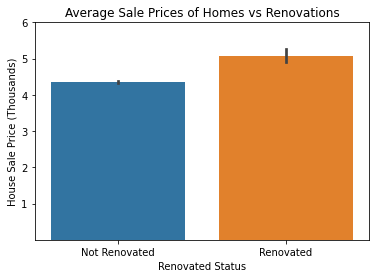

In [334]:
sns.barplot(data = df, x='renovated', y='price')
plt.ylabel('House Sale Price (Thousands)')
plt.title('Average Sale Prices of Homes vs Renovations')
plt.yticks(ticks=[100000,200000,300000,400000,500000,600000],labels=[1,2,3,4,5,6])
plt.xticks(ticks=[0,1],labels=['Not Renovated','Renovated'])
plt.xlabel('Renovated Status')

# Prepare Data for Modeling



### Correlation Check

We'll run an initial check on correlations to see which variables we should start building the model with. 



In [335]:
# ranking the most highly correlated values

corrs = df.corr()['price'].map(abs).sort_values(ascending=False)
corrs

price                1.000000
grade                0.544684
sqft_living          0.520823
bathrooms            0.365673
bedrooms             0.229974
floors               0.224902
basement             0.169452
renovated            0.069978
sqft_lot             0.059972
waterfront_binary    0.043657
yrs_since_built      0.009850
Name: price, dtype: float64

<AxesSubplot:>

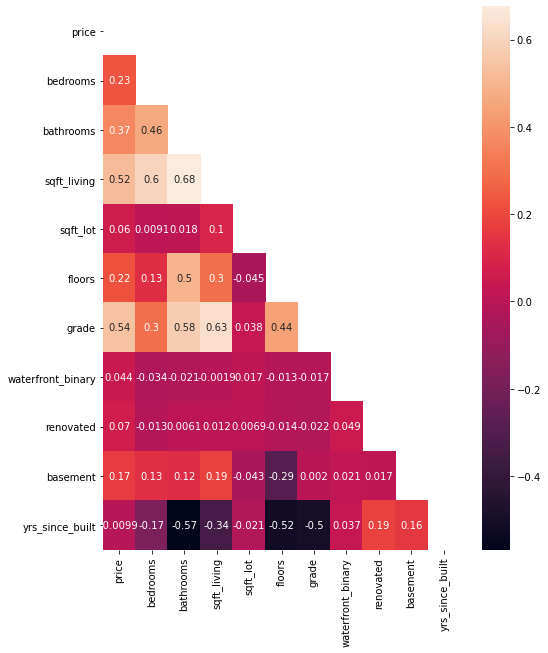

In [336]:
#visualizing the most highly correlated values

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(8,10))

corr = df.corr()
sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), ax=ax, annot=True)

The data above tells me that we should start our baseline model with the highest 
correlated values, I'll begin with grade, sqft_living and bathrooms. 

I've also noticed that yrs_since_built has a very low correlations with price. I'll look at the visualizations and consider removing this feature. 

### Normalizing Data

Normalize the numeric columns to the same scale and create a function to do so for future analysis. Data normalization is very important as it allows us to compare all of our data on the same scale and see which data sets have a greater impact on the model, even though they might be different relative sizes. 

Moving forward, I'll keep two separate copies of my data; one that has been normalized, and one that has not. This will allow me to compare coefficients with normalized data and extract real values based on those coefficiants from the data set that has not been normalized. 


In [337]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,waterfront_binary,renovated,basement,yrs_since_built
0,221900.0,3,1.00,1180,5650,1.0,NONE,Average,7,0,0,0,67
1,538000.0,3,2.25,2570,7242,2.0,NONE,Average,7,0,1,1,71
2,180000.0,2,1.00,770,10000,1.0,NONE,Average,6,0,0,0,89
3,604000.0,4,3.00,1960,5000,1.0,NONE,Very Good,7,0,0,1,57
4,510000.0,3,2.00,1680,8080,1.0,NONE,Average,8,0,0,0,35


In [338]:
df_norm = df.copy()

In [339]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18235 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              18235 non-null  float64
 1   bedrooms           18235 non-null  int64  
 2   bathrooms          18235 non-null  float64
 3   sqft_living        18235 non-null  int64  
 4   sqft_lot           18235 non-null  int64  
 5   floors             18235 non-null  float64
 6   view               18235 non-null  object 
 7   condition          18235 non-null  object 
 8   grade              18235 non-null  int64  
 9   waterfront_binary  18235 non-null  int64  
 10  renovated          18235 non-null  int64  
 11  basement           18235 non-null  int64  
 12  yrs_since_built    18235 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 2.5+ MB


In [340]:
y = df_norm['price']
x = df_norm.drop('price', axis=1)

In [341]:
def norm_feature(series):
    return((series - series.mean())/ series.std())


for feat in ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
             'grade','yrs_since_built']:
    df_norm[feat] = norm_feature(df_norm[feat])

df_norm


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,waterfront_binary,renovated,basement,yrs_since_built
0,221900.0,-0.275883,-1.474146,-1.051644,-0.209074,-0.822900,NONE,Average,-0.409901,0,0,0,0.504468
1,538000.0,-0.275883,0.453143,1.260322,-0.164343,1.044511,NONE,Average,-0.409901,0,1,1,0.642610
2,180000.0,-1.530739,-1.474146,-1.733591,-0.086850,-0.822900,NONE,Average,-1.516093,0,0,0,1.264250
3,604000.0,0.978974,1.609516,0.245718,-0.227338,-0.822900,NONE,Very Good,-0.409901,0,0,1,0.159112
4,510000.0,-0.275883,0.067685,-0.220002,-0.140797,-0.822900,NONE,Average,0.696291,0,0,0,-0.600671
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,-0.275883,0.838600,-0.469494,-0.336047,2.911923,NONE,Average,0.696291,0,0,0,-1.360454
21593,400000.0,0.978974,0.838600,0.827868,-0.204494,1.044511,NONE,Average,0.696291,0,0,0,-1.533132
21594,402101.0,-1.530739,-1.859603,-1.317770,-0.329894,1.044511,NONE,Average,-0.409901,0,0,0,-1.360454
21595,400000.0,-0.275883,0.838600,-0.353064,-0.300728,1.044511,NONE,Average,0.696291,0,0,0,-1.187776


### Dealing with Categorical Values


Using plots, determine which values are categorical and must be manipulated by one hot encoding, and which are continuous.  

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

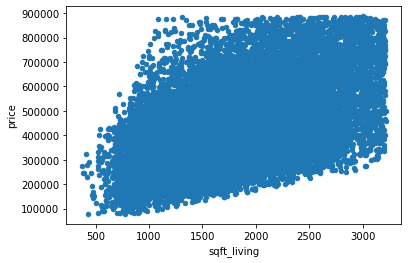

In [342]:
#based on the below graph, it does appear that sqft_living looks to be a 
#continuous variable

df.plot(kind='scatter', x='sqft_living', y='price')

<AxesSubplot:xlabel='sqft_lot', ylabel='price'>

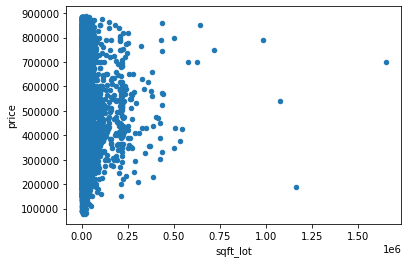

In [343]:
#interesting scatter pattern but we'll call this continuous

df.plot(kind='scatter', x='sqft_lot', y='price')

<AxesSubplot:xlabel='yrs_since_built', ylabel='price'>

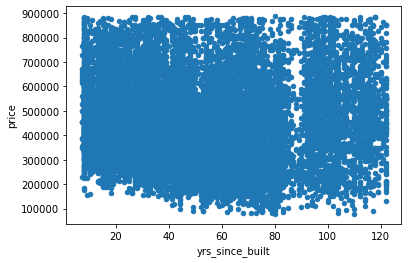

In [344]:
#this is interesting, it appears that prices do not have a linear relationship
# with yrs_since_built

df.plot(kind='scatter', x='yrs_since_built', y='price')

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

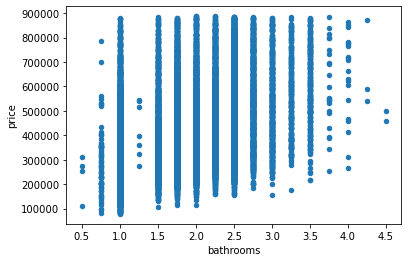

In [345]:
# could be either continuous or categorical, we'll go with continuous
# in an effort to not create too many features

df.plot(kind='scatter', x='bathrooms', y='price')

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

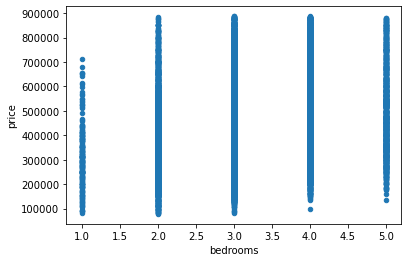

In [346]:
# bedrooms will be continuous

df.plot(kind='scatter', x='bedrooms', y='price')

In [347]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,yrs_since_built
count,18235.000000,18235.000000,18235.000000,18235.000000,1.823500e+04,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000
mean,437346.692350,3.219852,1.956101,1812.269262,1.309100e+04,1.440664,7.370551,0.002194,0.028078,0.359474,52.392816
std,170217.868134,0.796904,0.648580,601.219806,3.559026e+04,0.535501,0.904002,0.046786,0.165200,0.479859,28.955643
min,78000.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,3.000000,0.000000,0.000000,0.000000,7.000000
25%,302000.000000,3.000000,1.500000,1350.000000,5.000000e+03,1.000000,7.000000,0.000000,0.000000,0.000000,28.000000
50%,414000.000000,3.000000,2.000000,1760.000000,7.360000e+03,1.000000,7.000000,0.000000,0.000000,0.000000,51.000000
75%,550000.000000,4.000000,2.500000,2240.000000,9.947000e+03,2.000000,8.000000,0.000000,0.000000,1.000000,72.000000
max,887000.000000,5.000000,4.500000,3217.000000,1.651359e+06,3.500000,11.000000,1.000000,1.000000,1.000000,122.000000


<AxesSubplot:xlabel='grade', ylabel='price'>

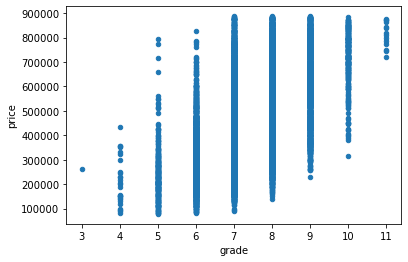

In [348]:
# grade will be continuous

df.plot(kind='scatter', x='grade', y='price')

And that's a wrap! 

Continuous Variables:
- bedrooms
- bathrooms
- grade
- sqft_living
- sqft_lot
- yrs_since_built
- floors

Categorical Variables:
- view
- condition
- waterfront_binary
- renovated
- basement

Next we'll created the categories using pd.get_dummies
and add them to both our scaled and unscaled data sets


In [349]:

view_dummies = pd.get_dummies(df['view'], prefix='View', drop_first=True)
condition_dummies = pd.get_dummies(df['condition'], prefix='Condition', drop_first=True)



In [350]:
view_dummies.head()

,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [351]:
df_norm_dummies = pd.concat([df_norm, view_dummies
                           , condition_dummies], axis=1)

df_dummies = pd.concat([df, view_dummies
                           , condition_dummies], axis=1)

In [352]:
df_norm_dummies.drop(['view','condition'], axis=1, inplace=True)
df_dummies.drop(['view','condition'], axis=1, inplace=True)

In [353]:
# normalized data with dummies

df_norm_dummies.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,yrs_since_built,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good
0,221900.0,-0.275883,-1.474146,-1.051644,-0.209074,-0.822900,-0.409901,0,0,0,0.504468,0,0,0,1,0,0,0,0
1,538000.0,-0.275883,0.453143,1.260322,-0.164343,1.044511,-0.409901,0,1,1,0.642610,0,0,0,1,0,0,0,0
2,180000.0,-1.530739,-1.474146,-1.733591,-0.086850,-0.822900,-1.516093,0,0,0,1.264250,0,0,0,1,0,0,0,0
3,604000.0,0.978974,1.609516,0.245718,-0.227338,-0.822900,-0.409901,0,0,1,0.159112,0,0,0,1,0,0,0,1
4,510000.0,-0.275883,0.067685,-0.220002,-0.140797,-0.822900,0.696291,0,0,0,-0.600671,0,0,0,1,0,0,0,0


In [354]:
# normal data with dummies

df_dummies.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,yrs_since_built,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good
0,221900.0,3,1.00,1180,5650,1.0,7,0,0,0,67,0,0,0,1,0,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,7,0,1,1,71,0,0,0,1,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,6,0,0,0,89,0,0,0,1,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,7,0,0,1,57,0,0,0,1,0,0,0,1
4,510000.0,3,2.00,1680,8080,1.0,8,0,0,0,35,0,0,0,1,0,0,0,0


# Data Exploration


In [355]:
# describe data set

df_norm_dummies.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,yrs_since_built,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good
count,18235.000000,1.823500e+04,1.823500e+04,1.823500e+04,1.823500e+04,1.823500e+04,1.823500e+04,18235.000000,18235.000000,18235.000000,1.823500e+04,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000
mean,437346.692350,-2.806395e-16,5.878648e-15,-9.422436e-17,2.812514e-16,6.453528e-15,4.870734e-18,0.002194,0.028078,0.359474,5.480916e-16,0.004661,0.011571,0.013381,0.937702,0.008884,0.271401,0.001481,0.076830
std,170217.868134,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.046786,0.165200,0.479859,1.000000e+00,0.068117,0.106948,0.114902,0.241702,0.093838,0.444695,0.038452,0.266329
min,78000.000000,-2.785595e+00,-2.245061e+00,-2.398905e+00,-3.532147e-01,-8.229002e-01,-4.834669e+00,0.000000,0.000000,0.000000,-1.567667e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,302000.000000,-2.758825e-01,-7.032304e-01,-7.688856e-01,-2.273375e-01,-8.229002e-01,-4.099007e-01,0.000000,0.000000,0.000000,-8.424201e-01,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,414000.000000,-2.758825e-01,6.768497e-02,-8.693869e-02,-1.610273e-01,-8.229002e-01,-4.099007e-01,0.000000,0.000000,0.000000,-4.810171e-02,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,550000.000000,9.789736e-01,8.386003e-01,7.114382e-01,-8.833885e-02,1.044511e+00,6.962914e-01,0.000000,0.000000,1.000000,6.771455e-01,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,887000.000000,2.233830e+00,3.922262e+00,2.336468e+00,4.603136e+01,3.845629e+00,4.014868e+00,1.000000,1.000000,1.000000,2.403925e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [356]:
df_dummies.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,yrs_since_built,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good
count,18235.000000,18235.000000,18235.000000,18235.000000,1.823500e+04,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000
mean,437346.692350,3.219852,1.956101,1812.269262,1.309100e+04,1.440664,7.370551,0.002194,0.028078,0.359474,52.392816,0.004661,0.011571,0.013381,0.937702,0.008884,0.271401,0.001481,0.076830
std,170217.868134,0.796904,0.648580,601.219806,3.559026e+04,0.535501,0.904002,0.046786,0.165200,0.479859,28.955643,0.068117,0.106948,0.114902,0.241702,0.093838,0.444695,0.038452,0.266329
min,78000.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,3.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,302000.000000,3.000000,1.500000,1350.000000,5.000000e+03,1.000000,7.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,414000.000000,3.000000,2.000000,1760.000000,7.360000e+03,1.000000,7.000000,0.000000,0.000000,0.000000,51.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,550000.000000,4.000000,2.500000,2240.000000,9.947000e+03,2.000000,8.000000,0.000000,0.000000,1.000000,72.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,887000.000000,5.000000,4.500000,3217.000000,1.651359e+06,3.500000,11.000000,1.000000,1.000000,1.000000,122.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [357]:
norm_feature(df['bathrooms'])

0       -1.474146
1        0.453143
2       -1.474146
3        1.609516
4        0.067685
           ...   
21592    0.838600
21593    0.838600
21594   -1.859603
21595    0.838600
21596   -1.859603
Name: bathrooms, Length: 18235, dtype: float64

## Checking for Normality and Linearity

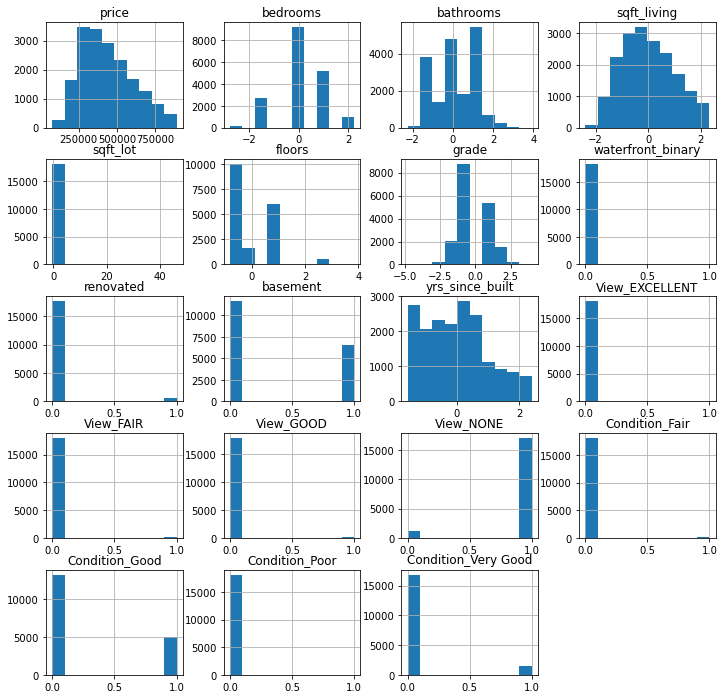

In [358]:
#plot histograms of the data set 

df_norm_dummies.hist(figsize=(12,12));

<AxesSubplot:>

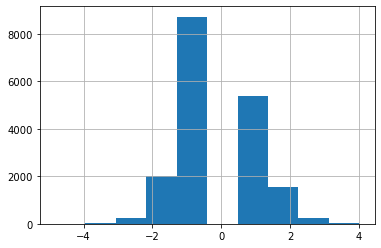

In [359]:
#drill down on grade

df_norm_dummies['grade'].hist()

<AxesSubplot:>

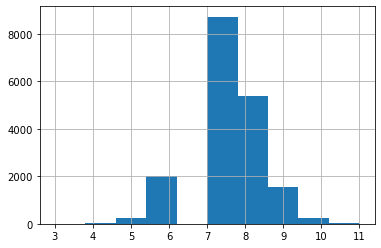

In [360]:
df_dummies['grade'].hist()

In [361]:
df_dummies['grade'].value_counts()

7     8728
8     5387
6     2019
9     1564
10     256
5      239
4       27
11      14
3        1
Name: grade, dtype: int64

In [362]:
#most of these distributions looks very skewed, so we'll check for linearity 
# in some of the variables

<AxesSubplot:>

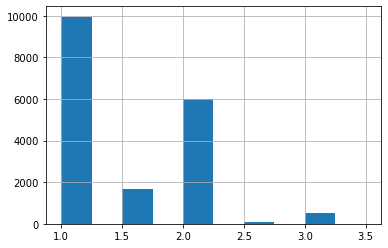

In [363]:
# drill down on floor

df_dummies['floors'].hist()

Observing the histograms above, most of the data seems to look rather normal, except for the following:

- yrs_since_built: much like the scatter plot and correlation value generated, this data looks randomly distributed
- grade: this variable appears to be bi-modal
- floors: this variable looks very heavily skewed

I'll start by dropping the yrs_since_built variable. Then I'll create addtional features for grade and floors. 

/Users/sarahborrmann/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


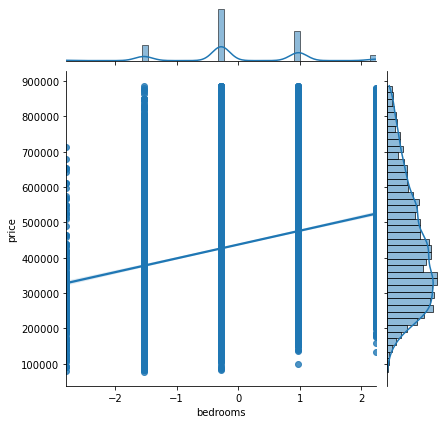

In [364]:
# this looks like a linear relationship

sns.jointplot('bedrooms','price', data=df_norm_dummies, kind='reg')

/Users/sarahborrmann/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


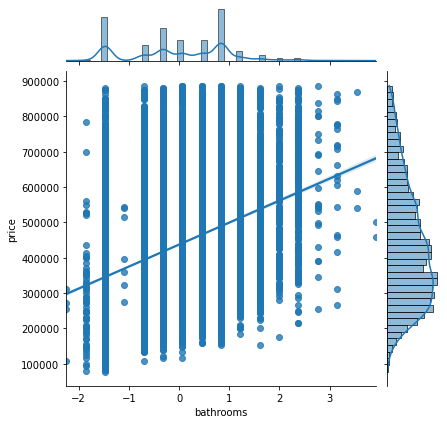

In [365]:
#this also looks like a linear relationship

sns.jointplot('bathrooms','price', data=df_norm_dummies, kind='reg')

/Users/sarahborrmann/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


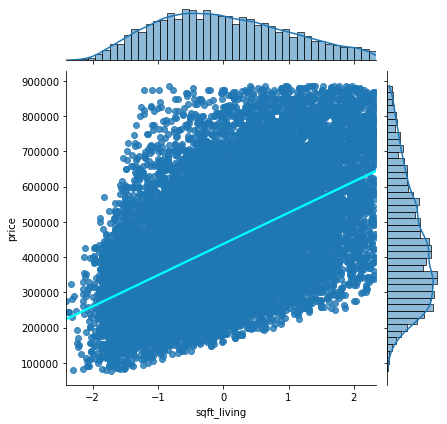

In [366]:
sns.jointplot('sqft_living','price', data=df_norm_dummies, kind='reg', 
             joint_kws={'line_kws':{'color':'cyan'}})


/Users/sarahborrmann/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


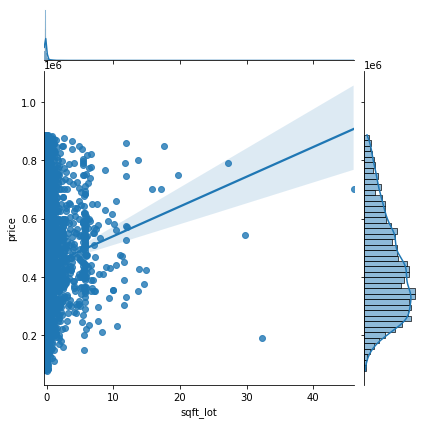

In [367]:
# the relationship between sqft_lot and price does seem to be linear
#but quite noisy as well

sns.jointplot('sqft_lot','price', data=df_norm_dummies, kind='reg')

/Users/sarahborrmann/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


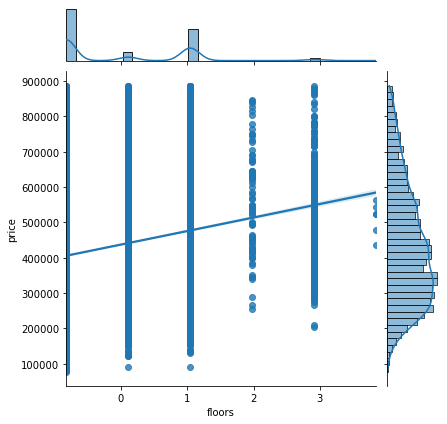

In [368]:
#very slight linear relationship between floors and price

sns.jointplot('floors','price', data=df_norm_dummies, kind='reg')

/Users/sarahborrmann/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


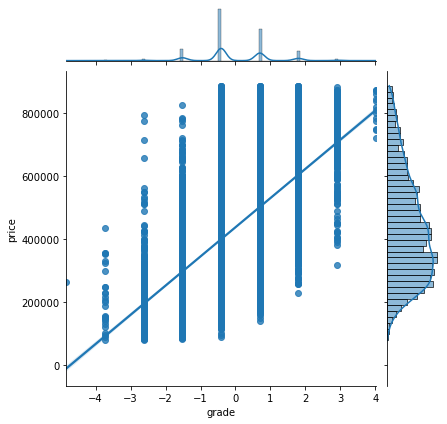

In [369]:
# looks like there is a linear relationship between grade and price

sns.jointplot('grade','price', data=df_norm_dummies, kind='reg')

/Users/sarahborrmann/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


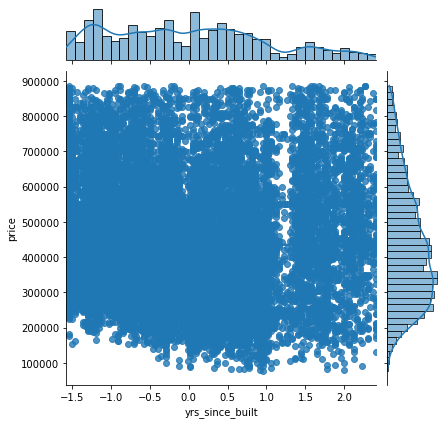

In [370]:
# not linear at all

sns.jointplot('yrs_since_built','price', data=df_norm_dummies, kind='reg')

/Users/sarahborrmann/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


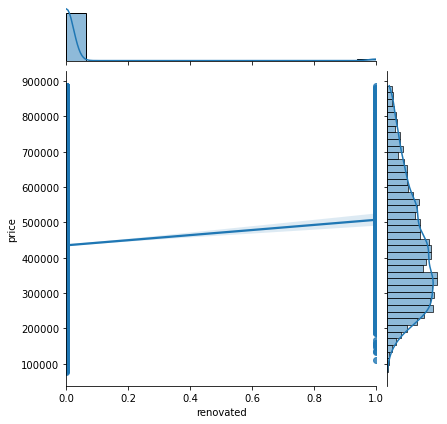

In [371]:
sns.jointplot('renovated','price', data=df_norm_dummies, kind='reg')

/Users/sarahborrmann/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


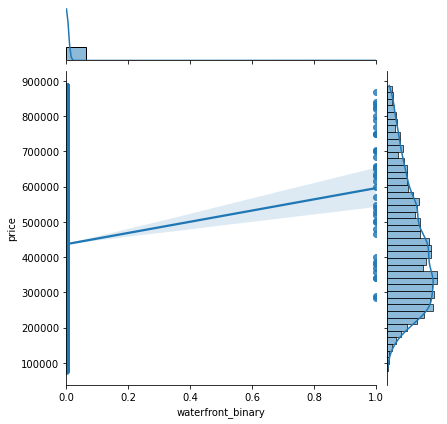

In [372]:
sns.jointplot('waterfront_binary','price', data=df_norm_dummies, kind='reg')

/Users/sarahborrmann/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


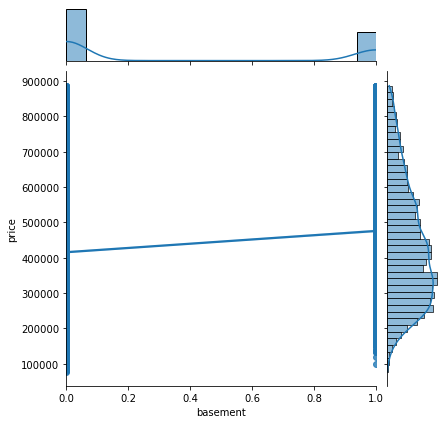

In [373]:
sns.jointplot('basement','price', data=df_norm_dummies, kind='reg')

## Feature Building and Data Cleaning

In this section I'll remove the 'yrs_since_built' variable and make new features for grade and floors. 

In [374]:
df_dummies.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,yrs_since_built,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good
0,221900.0,3,1.00,1180,5650,1.0,7,0,0,0,67,0,0,0,1,0,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,7,0,1,1,71,0,0,0,1,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,6,0,0,0,89,0,0,0,1,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,7,0,0,1,57,0,0,0,1,0,0,0,1
4,510000.0,3,2.00,1680,8080,1.0,8,0,0,0,35,0,0,0,1,0,0,0,0


In [375]:
# remove yrs since built from normal and normalized data sets
df_dummies = df_dummies.drop('yrs_since_built', axis=1)

In [376]:
df_norm_dummies.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,yrs_since_built,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good
0,221900.0,-0.275883,-1.474146,-1.051644,-0.209074,-0.822900,-0.409901,0,0,0,0.504468,0,0,0,1,0,0,0,0
1,538000.0,-0.275883,0.453143,1.260322,-0.164343,1.044511,-0.409901,0,1,1,0.642610,0,0,0,1,0,0,0,0
2,180000.0,-1.530739,-1.474146,-1.733591,-0.086850,-0.822900,-1.516093,0,0,0,1.264250,0,0,0,1,0,0,0,0
3,604000.0,0.978974,1.609516,0.245718,-0.227338,-0.822900,-0.409901,0,0,1,0.159112,0,0,0,1,0,0,0,1
4,510000.0,-0.275883,0.067685,-0.220002,-0.140797,-0.822900,0.696291,0,0,0,-0.600671,0,0,0,1,0,0,0,0


In [377]:
df_norm_dummies = df_norm_dummies.drop('yrs_since_built', axis=1)

<AxesSubplot:>

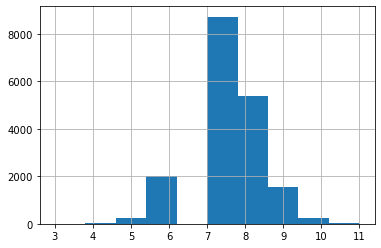

In [378]:
# evaluate grade again

df_dummies['grade'].hist()

In [379]:
# it looks like the data set is split between grades with 6 or lower and 
# grades with 7 or higher

df_dummies['high_grade'] = df_dummies['grade'].map(lambda x: 1 if x>=7 else 0)

In [380]:
df_dummies.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good,high_grade
0,221900.0,3,1.00,1180,5650,1.0,7,0,0,0,0,0,0,1,0,0,0,0,1
1,538000.0,3,2.25,2570,7242,2.0,7,0,1,1,0,0,0,1,0,0,0,0,1
2,180000.0,2,1.00,770,10000,1.0,6,0,0,0,0,0,0,1,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,7,0,0,1,0,0,0,1,0,0,0,1,1
4,510000.0,3,2.00,1680,8080,1.0,8,0,0,0,0,0,0,1,0,0,0,0,1


In [381]:
df_dummies.groupby('high_grade').mean()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good
high_grade,,,,,,,,,,,,,,,,,,
0,291803.732283,2.623360,1.219488,1155.265529,13772.552493,1.103675,5.870516,0.005687,0.033683,0.205599,0.006562,0.008311,0.006562,0.957568,0.033683,0.336833,0.009186,0.122922
1,458207.637031,3.305348,2.061681,1906.438836,12993.314941,1.488965,7.585554,0.001693,0.027274,0.381529,0.004389,0.012038,0.014358,0.934855,0.005329,0.262023,0.000376,0.070224


In [382]:
# normalize the data

high_grade = df_dummies['high_grade']

In [383]:
# add the new normalied field to the normalized data set
df_norm_dummies = pd.concat([df_norm_dummies, high_grade], axis=1
         )

In [384]:
df_norm_dummies.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good,high_grade
0,221900.0,-0.275883,-1.474146,-1.051644,-0.209074,-0.822900,-0.409901,0,0,0,0,0,0,1,0,0,0,0,1
1,538000.0,-0.275883,0.453143,1.260322,-0.164343,1.044511,-0.409901,0,1,1,0,0,0,1,0,0,0,0,1
2,180000.0,-1.530739,-1.474146,-1.733591,-0.086850,-0.822900,-1.516093,0,0,0,0,0,0,1,0,0,0,0,0
3,604000.0,0.978974,1.609516,0.245718,-0.227338,-0.822900,-0.409901,0,0,1,0,0,0,1,0,0,0,1,1
4,510000.0,-0.275883,0.067685,-0.220002,-0.140797,-0.822900,0.696291,0,0,0,0,0,0,1,0,0,0,0,1


<AxesSubplot:>

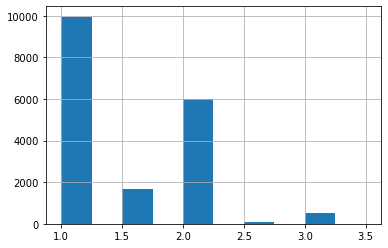

In [385]:
df_dummies['floors'].hist()

In [386]:
# it looks like most houses have at least 1 floor(makes sense)
# we'll add a feature that splits houses between having 1 floor or greater than 
# one floor

df_dummies.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good,high_grade
count,18235.000000,18235.000000,18235.000000,18235.000000,1.823500e+04,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000,18235.000000
mean,437346.692350,3.219852,1.956101,1812.269262,1.309100e+04,1.440664,7.370551,0.002194,0.028078,0.359474,0.004661,0.011571,0.013381,0.937702,0.008884,0.271401,0.001481,0.076830,0.874637
std,170217.868134,0.796904,0.648580,601.219806,3.559026e+04,0.535501,0.904002,0.046786,0.165200,0.479859,0.068117,0.106948,0.114902,0.241702,0.093838,0.444695,0.038452,0.266329,0.331139
min,78000.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,302000.000000,3.000000,1.500000,1350.000000,5.000000e+03,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,414000.000000,3.000000,2.000000,1760.000000,7.360000e+03,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,550000.000000,4.000000,2.500000,2240.000000,9.947000e+03,2.000000,8.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,887000.000000,5.000000,4.500000,3217.000000,1.651359e+06,3.500000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [387]:
# check for any data that shows a house that has less than 1 floor


df_dummies[df_dummies['floors']< 1]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good,high_grade


In [388]:
# confirmed that zero houses have less than 1 floor 

In [389]:
df_dummies['one_floor'] = df_dummies['floors'].map(lambda x: 0 if x == 1 else 1)

In [390]:
df_dummies.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good,high_grade,one_floor
0,221900.0,3,1.00,1180,5650,1.0,7,0,0,0,0,0,0,1,0,0,0,0,1,0
1,538000.0,3,2.25,2570,7242,2.0,7,0,1,1,0,0,0,1,0,0,0,0,1,1
2,180000.0,2,1.00,770,10000,1.0,6,0,0,0,0,0,0,1,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,7,0,0,1,0,0,0,1,0,0,0,1,1,0
4,510000.0,3,2.00,1680,8080,1.0,8,0,0,0,0,0,0,1,0,0,0,0,1,0


In [391]:
one_floor = df_dummies['one_floor']

In [392]:
df_norm_dummies = pd.concat([df_norm_dummies, one_floor], axis=1)

In [393]:
df_norm_dummies.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good,high_grade,one_floor
0,221900.0,-0.275883,-1.474146,-1.051644,-0.209074,-0.822900,-0.409901,0,0,0,0,0,0,1,0,0,0,0,1,0
1,538000.0,-0.275883,0.453143,1.260322,-0.164343,1.044511,-0.409901,0,1,1,0,0,0,1,0,0,0,0,1,1
2,180000.0,-1.530739,-1.474146,-1.733591,-0.086850,-0.822900,-1.516093,0,0,0,0,0,0,1,0,0,0,0,0,0
3,604000.0,0.978974,1.609516,0.245718,-0.227338,-0.822900,-0.409901,0,0,1,0,0,0,1,0,0,0,1,1,0
4,510000.0,-0.275883,0.067685,-0.220002,-0.140797,-0.822900,0.696291,0,0,0,0,0,0,1,0,0,0,0,1,0


In [394]:
# check correlations again

corrs = df_dummies.corr()['price'].map(abs).sort_values(ascending=False)
corrs

price                  1.000000
grade                  0.544684
sqft_living            0.520823
bathrooms              0.365673
high_grade             0.323720
one_floor              0.249179
bedrooms               0.229974
floors                 0.224902
View_NONE              0.188809
basement               0.169452
View_GOOD              0.090000
View_EXCELLENT         0.080804
Condition_Fair         0.079551
View_FAIR              0.076457
renovated              0.069978
Condition_Very Good    0.063482
sqft_lot               0.059972
waterfront_binary      0.043657
Condition_Poor         0.032259
Condition_Good         0.011404
Name: price, dtype: float64

## Evaluating Multicolinearity

Multicolineartity could affect our resulting model, so we'll look for pairwise correlations that are higher than .65. 

In [395]:
feats = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'grade', 'waterfront_binary','renovated',
         'basement', 'high_grade','one_floor']

corr = df_norm_dummies[feats].corr()
corr

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,high_grade,one_floor
bedrooms,1.000000,0.458625,0.601351,0.009135,0.128949,0.297009,-0.033529,-0.012733,0.132211,0.283388,0.188554
bathrooms,0.458625,1.000000,0.676096,0.018365,0.499038,0.577138,-0.020774,0.006130,0.122206,0.429991,0.451877
sqft_living,0.601351,0.676096,1.000000,0.101723,0.298218,0.633386,-0.001901,0.011615,0.187420,0.413731,0.336455
sqft_lot,0.009135,0.018365,0.101723,1.000000,-0.045243,0.037685,0.017168,0.006917,-0.043186,-0.007250,-0.023820
floors,0.128949,0.499038,0.298218,-0.045243,1.000000,0.440178,-0.013411,-0.014023,-0.290588,0.238253,0.902129
grade,0.297009,0.577138,0.633386,0.037685,0.440178,1.000000,-0.016626,-0.021565,0.002028,0.628225,0.395877
waterfront_binary,-0.033529,-0.020774,-0.001901,0.017168,-0.013411,-0.016626,1.000000,0.048796,0.021060,-0.028268,-0.012165
renovated,-0.012733,0.006130,0.011615,0.006917,-0.014023,-0.021565,0.048796,1.000000,0.016569,-0.012846,0.004307
basement,0.132211,0.122206,0.187420,-0.043186,-0.290588,0.002028,0.021060,0.016569,1.000000,0.121405,-0.285811
high_grade,0.283388,0.429991,0.413731,-0.007250,0.238253,0.628225,-0.028268,-0.012846,0.121405,1.000000,0.209973


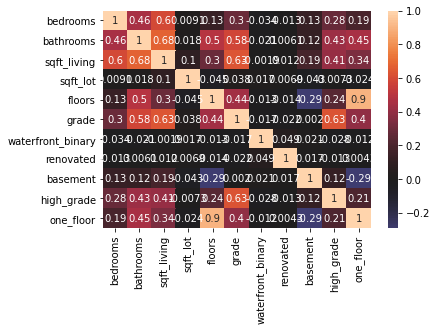

In [396]:
sns.heatmap(corr, center=0, annot=True);

In [397]:
abs(df_norm_dummies[feats].corr()) > .65

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,high_grade,one_floor
bedrooms,True,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,True,False,False,False,False,False,False,False,False
sqft_living,False,True,True,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False,False,False
floors,False,False,False,False,True,False,False,False,False,False,True
grade,False,False,False,False,False,True,False,False,False,False,False
waterfront_binary,False,False,False,False,False,False,True,False,False,False,False
renovated,False,False,False,False,False,False,False,True,False,False,False
basement,False,False,False,False,False,False,False,False,True,False,False
high_grade,False,False,False,False,False,False,False,False,False,True,False


In [398]:
#generate a list of pairs that correlate

dfc=df_norm_dummies[feats].corr().abs().stack().reset_index().sort_values(0, ascending=False)
dfc['pairs'] = list(zip(dfc.level_0, dfc.level_1))
dfc.set_index(['pairs'], inplace = True)
dfc.drop(columns=['level_1', 'level_0'], inplace = True)
dfc.columns = ['cc']
dfc.drop_duplicates(inplace=True)

dfc[(dfc.cc>.65) & (dfc.cc <1)]

,cc
pairs,
"(one_floor, floors)",0.902129
"(sqft_living, bathrooms)",0.676096


I should be conscious that these variables may be colinear. 

As I noted above, it looks like my 'one_floor' feature is correlating a bit better with price than the 'floors' variable. Since one_floor and floors are so highly correlated, I'll drop floors from my modeling. 

In [399]:
df_dummies = df_dummies.drop('floors', axis = 1)
df_norm_dummies = df_norm_dummies.drop('floors', axis=1)

# Modeling Data




In [400]:
df_norm_dummies.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,waterfront_binary,renovated,basement,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good,high_grade,one_floor
0,221900.0,-0.275883,-1.474146,-1.051644,-0.209074,-0.409901,0,0,0,0,0,0,1,0,0,0,0,1,0
1,538000.0,-0.275883,0.453143,1.260322,-0.164343,-0.409901,0,1,1,0,0,0,1,0,0,0,0,1,1
2,180000.0,-1.530739,-1.474146,-1.733591,-0.086850,-1.516093,0,0,0,0,0,0,1,0,0,0,0,0,0
3,604000.0,0.978974,1.609516,0.245718,-0.227338,-0.409901,0,0,1,0,0,0,1,0,0,0,1,1,0
4,510000.0,-0.275883,0.067685,-0.220002,-0.140797,0.696291,0,0,0,0,0,0,1,0,0,0,0,1,0


In [401]:
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

In [402]:
# make sure that there's no unnecessary punctuation in the columns

subs = [(' ', '_'),('.',''),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_')
       ]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

df_norm_dummies.columns = [col_formatting(col) for col in df_norm_dummies.columns]

In [403]:
df_dummies.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,waterfront_binary,renovated,basement,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good,high_grade,one_floor
0,221900.0,3,1.00,1180,5650,7,0,0,0,0,0,0,1,0,0,0,0,1,0
1,538000.0,3,2.25,2570,7242,7,0,1,1,0,0,0,1,0,0,0,0,1,1
2,180000.0,2,1.00,770,10000,6,0,0,0,0,0,0,1,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,7,0,0,1,0,0,0,1,0,0,0,1,1,0
4,510000.0,3,2.00,1680,8080,8,0,0,0,0,0,0,1,0,0,0,0,1,0


## Baseline Model

Create a baseline model using the top three variables that correlated best with 'price'

In [404]:


baseline_df = df_norm_dummies.filter(['price', 'bathrooms', 'sqft_living', 'grade'], axis=1)


In [405]:
baseline_df.head()

,price,bathrooms,sqft_living,grade
0,221900.0,-1.474146,-1.051644,-0.409901
1,538000.0,0.453143,1.260322,-0.409901
2,180000.0,-1.474146,-1.733591,-1.516093
3,604000.0,1.609516,0.245718,-0.409901
4,510000.0,0.067685,-0.220002,0.696291


In [406]:
outcome = baseline_df['price']
x_cols = baseline_df.drop('price', axis=1 )
predictors = sm.add_constant(x_cols)


In [407]:
import statsmodels.api as sm

model = sm.OLS(endog=outcome, exog=predictors).fit()

In [408]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     3293.
Date:                Mon, 03 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:40:12   Log-Likelihood:            -2.4156e+05
No. Observations:               18235   AIC:                         4.831e+05
Df Residuals:                   18231   BIC:                         4.832e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.373e+05   1015.219    430.791      0.000    4.35e+05    4.39e+05
bathrooms   -1.342e+04   1427.427     -9.398      0.000   -1.62e+04   -1.06e+04
sqft_living  5.694e+04   1506.396     37.797      0.000     5.4e+04    5.99e+04
grade        6.439e+04   1359.135     47.379      0.000    6.17e+04    6.71e+04
==============================================================================
Omnibus:                      609.556   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              670.329
Skew:                           0.467   Prob(JB):                    2.75e-146
Kurtosis:                       2.904   Cond. No.                         2.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Although we didn't get a very high R-squared score, the coefficients for the most correlated values suggest that grade, followed by sqft_living positively impact the price of the house. Adding more bathrooms may negatively affect the price. 

## First Iteration

Layer in the next three variables that correlated with 'price' which are bedrooms, one_floor and high_grade.

In [409]:
baseline_df = df_norm_dummies.filter(['price', 'bedrooms', 'grade',
                                      'bathrooms','sqft_living', 
                                      'high_grade', 'one_floor'], axis=1)

In [410]:
baseline_df.head()

,price,bedrooms,grade,bathrooms,sqft_living,high_grade,one_floor
0,221900.0,-0.275883,-0.409901,-1.474146,-1.051644,1,0
1,538000.0,-0.275883,-0.409901,0.453143,1.260322,1,1
2,180000.0,-1.530739,-1.516093,-1.474146,-1.733591,0,0
3,604000.0,0.978974,-0.409901,1.609516,0.245718,1,0
4,510000.0,-0.275883,0.696291,0.067685,-0.220002,1,0


In [411]:
outcome = baseline_df['price']
x_cols = baseline_df.drop('price', axis=1 )
predictors = sm.add_constant(x_cols)
model = sm.OLS(endog=outcome, exog=predictors).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     1679.
Date:                Mon, 03 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:40:12   Log-Likelihood:            -2.4150e+05
No. Observations:               18235   AIC:                         4.830e+05
Df Residuals:                   18228   BIC:                         4.831e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.416e+05   3878.909    113.839      0.000    4.34e+05    4.49e+05
bedrooms    -1.259e+04   1299.733     -9.690      0.000   -1.51e+04      -1e+04
grade        6.304e+04   1619.882     38.915      0.000    5.99e+04    6.62e+04
bathrooms   -1.282e+04   1502.259     -8.536      0.000   -1.58e+04   -9878.728
sqft_living  6.476e+04   1704.934     37.984      0.000    6.14e+04    6.81e+04
high_grade  -9526.3306   4000.029     -2.382      0.017   -1.74e+04   -1685.897
one_floor    9042.5120   2329.189      3.882      0.000    4477.083    1.36e+04
==============================================================================
Omnibus:                      632.586   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              699.874
Skew:                           0.479   Prob(JB):                    1.06e-152
Kurtosis:                       2.943   Cond. No.                         9.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Although the model did not get that much stronger adding in the new variables increased the coefficiant for sqft_living, and bathrooms remained a negative coefficient. 






## Second Iteration

Add the next three most correlated values to sale price. 

In [412]:
baseline_df = df_norm_dummies.filter(['price', 'bedrooms', 'grade',
                                      'bathrooms','sqft_living', 
                                      'high_grade', 'one_floor'
                                     , 'View_NONE', 'basement', 'View_GOOD'], axis=1)

In [413]:
outcome = baseline_df['price']
x_cols = baseline_df.drop('price', axis=1 )
predictors = sm.add_constant(x_cols)
model = sm.OLS(endog=outcome, exog=predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     1285.
Date:                Mon, 03 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:40:12   Log-Likelihood:            -2.4103e+05
No. Observations:               18235   AIC:                         4.821e+05
Df Residuals:                   18225   BIC:                         4.822e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.979e+05   5830.487     85.389      0.000    4.86e+05    5.09e+05
bedrooms    -1.023e+04   1270.181     -8.055      0.000   -1.27e+04   -7740.998
grade        6.729e+04   1597.825     42.116      0.000    6.42e+04    7.04e+04
bathrooms   -1.672e+04   1478.573    -11.306      0.000   -1.96e+04   -1.38e+04
sqft_living  5.393e+04   1700.640     31.712      0.000    5.06e+04    5.73e+04
high_grade   -1.94e+04   3932.737     -4.932      0.000   -2.71e+04   -1.17e+04
one_floor    3.257e+04   2445.952     13.314      0.000    2.78e+04    3.74e+04
View_NONE   -8.202e+04   4633.383    -17.702      0.000   -9.11e+04   -7.29e+04
basement     5.223e+04   2318.999     22.521      0.000    4.77e+04    5.68e+04
View_GOOD   -1.507e+04   9628.421     -1.565      0.118   -3.39e+04    3802.123
==============================================================================
Omnibus:                      575.914   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              631.828
Skew:                           0.456   Prob(JB):                    6.31e-138
Kurtosis:                       3.025   Cond. No.                         18.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The score has sligtly improved and we haven't seen much change the most highly correlating values. 

We do notice that there's a high p-value in view_good, we'll add the next set of variables to the model and remove view_good. 

## Third Iteration

Remove high p-value variable 'View_GOOD' and add next three highest correlating values. 

In [414]:
baseline_df = df_norm_dummies.filter(['price', 'bedrooms', 'grade',
                                      'bathrooms','sqft_living', 
                                      'high_grade', 'one_floor'
                                     , 'View_NONE', 'basement', 
                                     'View_Excellent','Condition_Fair',
                                     'View_FAIR'], axis=1)

In [415]:
baseline_df.head()

,price,bedrooms,grade,bathrooms,sqft_living,high_grade,one_floor,View_NONE,basement,Condition_Fair,View_FAIR
0,221900.0,-0.275883,-0.409901,-1.474146,-1.051644,1,0,1,0,0,0
1,538000.0,-0.275883,-0.409901,0.453143,1.260322,1,1,1,1,0,0
2,180000.0,-1.530739,-1.516093,-1.474146,-1.733591,0,0,1,0,0,0
3,604000.0,0.978974,-0.409901,1.609516,0.245718,1,0,1,1,0,0
4,510000.0,-0.275883,0.696291,0.067685,-0.220002,1,0,1,0,0,0


In [416]:
outcome = baseline_df['price']
x_cols = baseline_df.drop(['price'], axis=1 )
predictors = sm.add_constant(x_cols)
model = sm.OLS(endog=outcome, exog=predictors).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     1159.
Date:                Mon, 03 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:40:12   Log-Likelihood:            -2.4102e+05
No. Observations:               18235   AIC:                         4.821e+05
Df Residuals:                   18224   BIC:                         4.822e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.948e+05   5746.618     86.098      0.000    4.84e+05    5.06e+05
bedrooms       -1.027e+04   1269.566     -8.086      0.000   -1.28e+04   -7777.217
grade           6.715e+04   1597.549     42.036      0.000     6.4e+04    7.03e+04
bathrooms      -1.682e+04   1478.006    -11.382      0.000   -1.97e+04   -1.39e+04
sqft_living     5.387e+04   1699.479     31.699      0.000    5.05e+04    5.72e+04
high_grade     -2.027e+04   3935.742     -5.150      0.000    -2.8e+04   -1.26e+04
one_floor       3.249e+04   2444.928     13.288      0.000    2.77e+04    3.73e+04
View_NONE      -7.771e+04   4554.483    -17.062      0.000   -8.66e+04   -6.88e+04
basement        5.225e+04   2317.872     22.543      0.000    4.77e+04    5.68e+04
Condition_Fair -4.793e+04   1.06e+04     -4.534      0.000   -6.87e+04   -2.72e+04
View_FAIR       5189.3602   1.02e+04      0.511      0.610   -1.47e+04    2.51e+04
==============================================================================
Omnibus:                      580.952   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              637.868
Skew:                           0.458   Prob(JB):                    3.08e-139
Kurtosis:                       3.025   Cond. No.                         19.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Fourth Iteration

Let's add the final variables and remove the high p-score from the last model.

In [417]:
baseline_df.head()

,price,bedrooms,grade,bathrooms,sqft_living,high_grade,one_floor,View_NONE,basement,Condition_Fair,View_FAIR
0,221900.0,-0.275883,-0.409901,-1.474146,-1.051644,1,0,1,0,0,0
1,538000.0,-0.275883,-0.409901,0.453143,1.260322,1,1,1,1,0,0
2,180000.0,-1.530739,-1.516093,-1.474146,-1.733591,0,0,1,0,0,0
3,604000.0,0.978974,-0.409901,1.609516,0.245718,1,0,1,1,0,0
4,510000.0,-0.275883,0.696291,0.067685,-0.220002,1,0,1,0,0,0


In [418]:
baseline_df = df_norm_dummies.drop(['View_GOOD','View_FAIR'], axis=1)

In [419]:
baseline_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,waterfront_binary,renovated,basement,View_EXCELLENT,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very_Good,high_grade,one_floor
0,221900.0,-0.275883,-1.474146,-1.051644,-0.209074,-0.409901,0,0,0,0,1,0,0,0,0,1,0
1,538000.0,-0.275883,0.453143,1.260322,-0.164343,-0.409901,0,1,1,0,1,0,0,0,0,1,1
2,180000.0,-1.530739,-1.474146,-1.733591,-0.086850,-1.516093,0,0,0,0,1,0,0,0,0,0,0
3,604000.0,0.978974,1.609516,0.245718,-0.227338,-0.409901,0,0,1,0,1,0,0,0,1,1,0
4,510000.0,-0.275883,0.067685,-0.220002,-0.140797,0.696291,0,0,0,0,1,0,0,0,0,1,0


In [420]:
outcome = baseline_df['price']
x_cols = baseline_df.drop('price', axis=1 )
predictors = sm.add_constant(x_cols)
model = sm.OLS(endog=outcome, exog=predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     801.3
Date:                Mon, 03 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:40:12   Log-Likelihood:            -2.4065e+05
No. Observations:               18235   AIC:                         4.813e+05
Df Residuals:                   18218   BIC:                         4.815e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4.651e+05   5571.163     83.477      0.000    4.54e+05    4.76e+05
bedrooms            -1.141e+04   1250.716     -9.120      0.000   -1.39e+04   -8954.950
bathrooms           -1.497e+04   1456.458    -10.277      0.000   -1.78e+04   -1.21e+04
sqft_living          5.064e+04   1685.656     30.041      0.000    4.73e+04    5.39e+04
sqft_lot             2619.8937    984.314      2.662      0.008     690.546    4549.242
grade                7.216e+04   1577.816     45.736      0.000    6.91e+04    7.53e+04
waterfront_binary    3.022e+04   2.44e+04      1.237      0.216   -1.77e+04    7.81e+04
renovated            7.658e+04   5878.809     13.026      0.000    6.51e+04    8.81e+04
basement             4.983e+04   2284.462     21.811      0.000    4.53e+04    5.43e+04
View_EXCELLENT       6.185e+04   1.71e+04      3.617      0.000    2.83e+04    9.54e+04
View_NONE           -6.756e+04   4227.731    -15.981      0.000   -7.58e+04   -5.93e+04
Condition_Fair      -2.806e+04   1.04e+04     -2.692      0.007   -4.85e+04   -7629.719
Condition_Good       3.279e+04   2319.025     14.141      0.000    2.82e+04    3.73e+04
Condition_Poor       1.762e+04   2.53e+04      0.698      0.485   -3.19e+04    6.71e+04
Condition_Very_Good  8.328e+04   3768.748     22.099      0.000    7.59e+04    9.07e+04
high_grade          -2.032e+04   3862.920     -5.260      0.000   -2.79e+04   -1.27e+04
one_floor            3.944e+04   2432.165     16.217      0.000    3.47e+04    4.42e+04
==============================================================================
Omnibus:                      469.309   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              506.116
Skew:                           0.408   Prob(JB):                    1.25e-110
Kurtosis:                       3.019   Cond. No.                         49.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [421]:
#try dropping high p values

## Fifth Iteration

Remove high p-values waterfront_binary condition_poor

In [422]:
baseline_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,waterfront_binary,renovated,basement,View_EXCELLENT,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very_Good,high_grade,one_floor
0,221900.0,-0.275883,-1.474146,-1.051644,-0.209074,-0.409901,0,0,0,0,1,0,0,0,0,1,0
1,538000.0,-0.275883,0.453143,1.260322,-0.164343,-0.409901,0,1,1,0,1,0,0,0,0,1,1
2,180000.0,-1.530739,-1.474146,-1.733591,-0.086850,-1.516093,0,0,0,0,1,0,0,0,0,0,0
3,604000.0,0.978974,1.609516,0.245718,-0.227338,-0.409901,0,0,1,0,1,0,0,0,1,1,0
4,510000.0,-0.275883,0.067685,-0.220002,-0.140797,0.696291,0,0,0,0,1,0,0,0,0,1,0


In [423]:
baseline_df = baseline_df.drop(['waterfront_binary','Condition_Poor'], axis=1)

In [424]:
outcome = baseline_df['price']
x_cols = baseline_df.drop('price', axis=1 )
predictors = sm.add_constant(x_cols)
model = sm.OLS(endog=outcome, exog=predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     915.6
Date:                Mon, 03 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:40:13   Log-Likelihood:            -2.4065e+05
No. Observations:               18235   AIC:                         4.813e+05
Df Residuals:                   18220   BIC:                         4.815e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4.655e+05   5563.010     83.674      0.000    4.55e+05    4.76e+05
bedrooms            -1.144e+04   1250.461     -9.150      0.000   -1.39e+04   -8991.045
bathrooms           -1.499e+04   1456.393    -10.290      0.000   -1.78e+04   -1.21e+04
sqft_living          5.066e+04   1685.505     30.059      0.000    4.74e+04     5.4e+04
sqft_lot             2636.1145    984.236      2.678      0.007     706.920    4565.309
grade                 7.21e+04   1576.988     45.720      0.000     6.9e+04    7.52e+04
renovated            7.679e+04   5875.728     13.069      0.000    6.53e+04    8.83e+04
basement             4.982e+04   2284.335     21.810      0.000    4.53e+04    5.43e+04
View_EXCELLENT       7.296e+04   1.47e+04      4.953      0.000    4.41e+04    1.02e+05
View_NONE           -6.783e+04   4222.537    -16.064      0.000   -7.61e+04   -5.96e+04
Condition_Fair      -2.824e+04   1.04e+04     -2.709      0.007   -4.87e+04   -7807.795
Condition_Good       3.275e+04   2317.357     14.134      0.000    2.82e+04    3.73e+04
Condition_Very_Good  8.322e+04   3767.578     22.089      0.000    7.58e+04    9.06e+04
high_grade          -2.045e+04   3860.126     -5.298      0.000    -2.8e+04   -1.29e+04
one_floor            3.945e+04   2432.120     16.222      0.000    3.47e+04    4.42e+04
==============================================================================
Omnibus:                      470.629   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              507.649
Skew:                           0.409   Prob(JB):                    5.83e-111
Kurtosis:                       3.019   Cond. No.                         27.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Investigate Multicolinearity Using VIF Scores

Finally, we'll use VIF scores to check the model for multicoliniearty. Any variable with a score greater than 10 we'll remove and re run the model. 

In [425]:
b = sm.add_constant(x_cols)
b

,const,bedrooms,bathrooms,sqft_living,sqft_lot,grade,renovated,basement,View_EXCELLENT,View_NONE,Condition_Fair,Condition_Good,Condition_Very_Good,high_grade,one_floor
0,1.0,-0.275883,-1.474146,-1.051644,-0.209074,-0.409901,0,0,0,1,0,0,0,1,0
1,1.0,-0.275883,0.453143,1.260322,-0.164343,-0.409901,1,1,0,1,0,0,0,1,1
2,1.0,-1.530739,-1.474146,-1.733591,-0.086850,-1.516093,0,0,0,1,0,0,0,0,0
3,1.0,0.978974,1.609516,0.245718,-0.227338,-0.409901,0,1,0,1,0,0,1,1,0
4,1.0,-0.275883,0.067685,-0.220002,-0.140797,0.696291,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,1.0,-0.275883,0.838600,-0.469494,-0.336047,0.696291,0,0,0,1,0,0,0,1,1
21593,1.0,0.978974,0.838600,0.827868,-0.204494,0.696291,0,0,0,1,0,0,0,1,1
21594,1.0,-1.530739,-1.859603,-1.317770,-0.329894,-0.409901,0,0,0,1,0,0,0,1,1
21595,1.0,-0.275883,0.838600,-0.353064,-0.300728,0.696291,0,0,0,1,0,0,0,1,1


In [426]:

vif = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
list(zip(x_cols, vif))

[('bedrooms', 33.153303233435416),
 ('bathrooms', 1.6750333644544906),
 ('sqft_living', 2.272168671611406),
 ('sqft_lot', 3.043289243991232),
 ('grade', 1.0377230834358215),
 ('renovated', 2.664035108449805),
 ('basement', 1.0093138056934907),
 ('View_EXCELLENT', 1.2871551329652022),
 ('View_NONE', 1.0784041879630706),
 ('Condition_Fair', 1.1158134242198776),
 ('Condition_Good', 1.0246052279010145),
 ('Condition_Very_Good', 1.1376095292032202),
 ('high_grade', 1.078563221167698),
 ('one_floor', 1.7502826943710246)]

## Final Iteration

We found that the variable for bedrooms was affected the model, let's remove it and get our final model. 

In [427]:
df_norm_dummies.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,waterfront_binary,renovated,basement,View_EXCELLENT,View_FAIR,View_GOOD,View_NONE,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very_Good,high_grade,one_floor
0,221900.0,-0.275883,-1.474146,-1.051644,-0.209074,-0.409901,0,0,0,0,0,0,1,0,0,0,0,1,0
1,538000.0,-0.275883,0.453143,1.260322,-0.164343,-0.409901,0,1,1,0,0,0,1,0,0,0,0,1,1
2,180000.0,-1.530739,-1.474146,-1.733591,-0.086850,-1.516093,0,0,0,0,0,0,1,0,0,0,0,0,0
3,604000.0,0.978974,1.609516,0.245718,-0.227338,-0.409901,0,0,1,0,0,0,1,0,0,0,1,1,0
4,510000.0,-0.275883,0.067685,-0.220002,-0.140797,0.696291,0,0,0,0,0,0,1,0,0,0,0,1,0


In [428]:
outcome = baseline_df['price']
df_preds = baseline_df.drop(['price', 'bedrooms'], axis=1)
predictors = sm.add_constant(df_preds)
model = sm.OLS(endog=outcome, exog=predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     975.1
Date:                Mon, 03 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:40:13   Log-Likelihood:            -2.4070e+05
No. Observations:               18235   AIC:                         4.814e+05
Df Residuals:                   18221   BIC:                         4.815e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4.714e+05   5537.894     85.121      0.000    4.61e+05    4.82e+05
bathrooms           -1.655e+04   1449.643    -11.415      0.000   -1.94e+04   -1.37e+04
sqft_living          4.344e+04   1492.386     29.106      0.000    4.05e+04    4.64e+04
sqft_lot             3165.3478    984.763      3.214      0.001    1235.120    5095.575
grade                7.483e+04   1551.985     48.217      0.000    7.18e+04    7.79e+04
renovated            7.803e+04   5887.495     13.253      0.000    6.65e+04    8.96e+04
basement             5.037e+04   2288.722     22.008      0.000    4.59e+04    5.49e+04
View_EXCELLENT        7.62e+04   1.48e+04      5.163      0.000    4.73e+04    1.05e+05
View_NONE           -6.999e+04   4225.491    -16.564      0.000   -7.83e+04   -6.17e+04
Condition_Fair      -2.817e+04   1.04e+04     -2.697      0.007   -4.86e+04   -7697.905
Condition_Good       3.142e+04   2318.034     13.555      0.000    2.69e+04     3.6e+04
Condition_Very_Good  8.157e+04   3771.796     21.627      0.000    7.42e+04     8.9e+04
high_grade          -2.475e+04   3840.055     -6.446      0.000   -3.23e+04   -1.72e+04
one_floor            3.971e+04   2437.470     16.293      0.000    3.49e+04    4.45e+04
==============================================================================
Omnibus:                      463.860   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              499.867
Skew:                           0.406   Prob(JB):                    2.85e-109
Kurtosis:                       3.001   Cond. No.                         27.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Coeffient Interpretation

Let's look at the final coefficients. 

It appears that increasing the grade and condition of the house are the greatest contributors to an increase in the sale price of the house. Great news! These are things that buyers often have control over. 

Having a excellent view will also greatly contribute to the sale price, but I'll focus on this less when giving advice to the reality company as it's difficult for home owners to control. However, if the customer had a view that was blocked by trees on the property, we'd suggest to have them cut back. 

The third variable that we'll consider is the overall square footage of the living space. The data above suggests we can't merely add an extra bathroom to the house if it doesn't make sense with the over all size of the house. Homeowners should carefully consider how they can increase living space, either by adding on to the house or or changing the space to provide more functionality (screened in porch for example). 




In [429]:
x_cols = baseline_df.columns

x_cols = ['price', 'bathrooms', 'sqft_living', 'sqft_lot', 'grade',
       'renovated', 'basement', 'View_EXCELLENT', 'View_NONE',
       'Condition_Fair', 'Condition_Good', 'Condition_Very Good', 'high_grade',
       'one_floor']



In [430]:
final = df_dummies[x_cols]

In [431]:
final.head()

,price,bathrooms,sqft_living,sqft_lot,grade,renovated,basement,View_EXCELLENT,View_NONE,Condition_Fair,Condition_Good,Condition_Very Good,high_grade,one_floor
0,221900.0,1.00,1180,5650,7,0,0,0,1,0,0,0,1,0
1,538000.0,2.25,2570,7242,7,1,1,0,1,0,0,0,1,1
2,180000.0,1.00,770,10000,6,0,0,0,1,0,0,0,0,0
3,604000.0,3.00,1960,5000,7,0,1,0,1,0,0,1,1,0
4,510000.0,2.00,1680,8080,8,0,0,0,1,0,0,0,1,0


In [432]:
outcome = final['price']
df_preds = final.drop('price', axis=1)
predictors = sm.add_constant(df_preds)
model = sm.OLS(endog=outcome, exog=predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     975.1
Date:                Mon, 03 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:40:13   Log-Likelihood:            -2.4070e+05
No. Observations:               18235   AIC:                         4.814e+05
Df Residuals:                   18221   BIC:                         4.815e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -2.209e+05   1.07e+04    -20.571      0.000   -2.42e+05      -2e+05
bathrooms           -2.551e+04   2235.103    -11.415      0.000   -2.99e+04   -2.11e+04
sqft_living            72.2480      2.482     29.106      0.000      67.383      77.114
sqft_lot                0.0889      0.028      3.214      0.001       0.035       0.143
grade                8.278e+04   1716.794     48.217      0.000    7.94e+04    8.61e+04
renovated            7.803e+04   5887.495     13.253      0.000    6.65e+04    8.96e+04
basement             5.037e+04   2288.722     22.008      0.000    4.59e+04    5.49e+04
View_EXCELLENT        7.62e+04   1.48e+04      5.163      0.000    4.73e+04    1.05e+05
View_NONE           -6.999e+04   4225.491    -16.564      0.000   -7.83e+04   -6.17e+04
Condition_Fair      -2.817e+04   1.04e+04     -2.697      0.007   -4.86e+04   -7697.905
Condition_Good       3.142e+04   2318.034     13.555      0.000    2.69e+04     3.6e+04
Condition_Very Good  8.157e+04   3771.796     21.627      0.000    7.42e+04     8.9e+04
high_grade          -2.475e+04   3840.055     -6.446      0.000   -3.23e+04   -1.72e+04
one_floor            3.971e+04   2437.470     16.293      0.000    3.49e+04    4.45e+04
==============================================================================
Omnibus:                      463.860   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              499.867
Skew:                           0.406   Prob(JB):                    2.85e-109
Kurtosis:                       3.001   Cond. No.                     5.84e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.84e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let's use the coefficiants found above to put them into plain terms that will make it easier to speak with homeowners. 

Increasing the Condition: The overall condition of a home is related to the maintenance of the house. A 'good' condition denotes that the home requires no obvious maintenance and that appearance and utility are above standard; this condition will increase the sale price of the house by about 31.5 thousand dollars if no other variables about the house are changed. 

However, having a home with a 'very good' condition will increase the sale price by about 81.5 thousand dollars. Houses that are in 'very good' condition are very will maintained, and show that many things have been overhauled and repaired over time, greatly increasing the life expectancy and utility of the home. 

Increasing Grade: Grade is represented on a 1 to 13 scale with a grade of 6 achieving the lowest grade to meet current building codes. Grades 7 and above generally mean that the house has increasing architectural design, better construction and higher overall design quality. In simpler terms, this can denote the quality of cosmetic appearance such as wood finishings and bathroom fixtures. Remodeling a home to increase by 1 grade point will yield an increase in price of about 83 thousand dollars. 

Increasing square footage of living space: For every square foot of living space, the home will increase in value by about 72 dollars. A better rule of thumb would be to frame this in a larger scale; adding a wreck room or family room on to the house that adds 500 square feet of living room will increase the sale price of the home by about 36 thousand dollars. 



Finally, a few visualizations to help communicate these variables to home owners

In [433]:
# visualizations

df.groupby('condition').mean()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,waterfront_binary,renovated,basement,yrs_since_built
condition,,,,,,,,,,,
Average,436515.889193,3.215202,2.049333,1852.874487,12270.675274,1.569554,7.514620,0.001539,0.035397,0.320451,44.319083
Fair,294326.783951,2.777778,1.416667,1345.740741,32159.777778,1.148148,6.475309,0.000000,0.018519,0.302469,72.938272
Good,434166.335825,3.230754,1.783593,1751.550616,14429.739947,1.215801,7.167913,0.003637,0.015155,0.419075,64.081431
Poor,294757.407407,2.407407,1.175926,1155.555556,22821.592593,1.129630,5.851852,0.037037,0.037037,0.111111,91.333333
Very Good,474802.648108,3.286938,1.864561,1754.372591,12817.820842,1.198787,7.016417,0.002141,0.013562,0.486081,75.379015


Text(0.5, 0, 'Overall Condition')

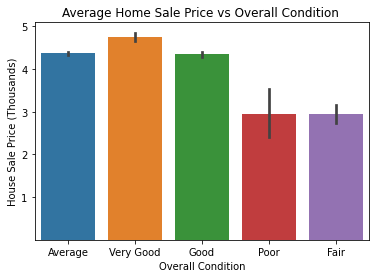

In [434]:
sns.barplot(data = df, x='condition', y='price')
plt.ylabel('House Sale Price (Thousands)')
plt.title('Average Home Sale Price vs Overall Condition ')
plt.yticks(ticks=[100000,200000,300000,400000,500000],labels=[1,2,3,4,5])
plt.xlabel('Overall Condition')

Text(0.5, 1.0, 'Simple Regression: Square Feet of Living Space vs Sale Price')

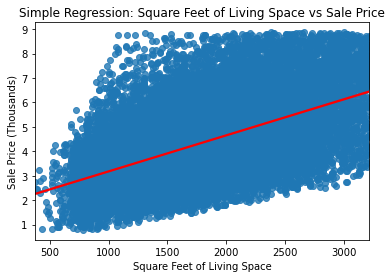

In [435]:
sns.regplot(x='sqft_living', y = 'price', data=df, scatter=True,line_kws={"color": "red"} )
plt.xlabel('Square Feet of Living Space')
plt.ylabel('Sale Price (Thousands)')
plt.yticks(ticks=[100000,200000,300000,400000,500000,600000,700000,800000,900000],labels=[1,2,3,4,5,6,7,8,9])
plt.title('Simple Regression: Square Feet of Living Space vs Sale Price')

Text(0.5, 1.0, 'Simple Regression: Grade vs Sale Price')

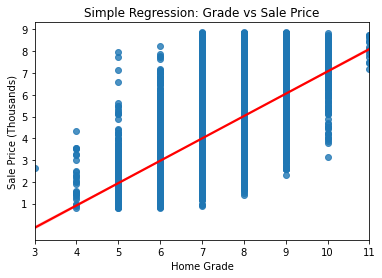

In [436]:
sns.regplot(x='grade', y='price', data=df_dummies, scatter=True,line_kws={"color": "red"})
plt.yticks(ticks=[100000,200000,300000,400000,500000,600000,700000,800000,900000],labels=[1,2,3,4,5,6,7,8,9])
plt.ylabel('Sale Price (Thousands)')
plt.xlabel('Home Grade')
plt.title('Simple Regression: Grade vs Sale Price')